## Лабораторная работа  по биометрии №5
<div style="text-align: right"> 
    Чангалиди Антон, P3214
<br>
   Исследование данных Электроэнцефалографии
</div>

### Цель:
Освоение методов спектрального анализа ритма ЭЭГ.

### Задание:
1. На портале https://physionet.org/ в разделе Data найти раздел Neuroelectric and Myoelectric Databases.

2. В разделе Neuroelectric and Myoelectric Databases выбрать EEG During Mental Arithmetic Tasks

3. Ознакомиться с визуализатором Visualize waveforms

4. На любой из последовательности, выявить все альфа волны (см. 1 часть методички)

5. Произвести спектральный анализ (см. 2 часть методички)

6. Сделать выводы о возможности использования ЭЭГ для нейроинтерфейсов.

### Выполнение


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### 1-3. Работа с сайтом
Зашел, скачал, посмотрел два файла + построил электроэнцефалограмму в визуализаторе: 

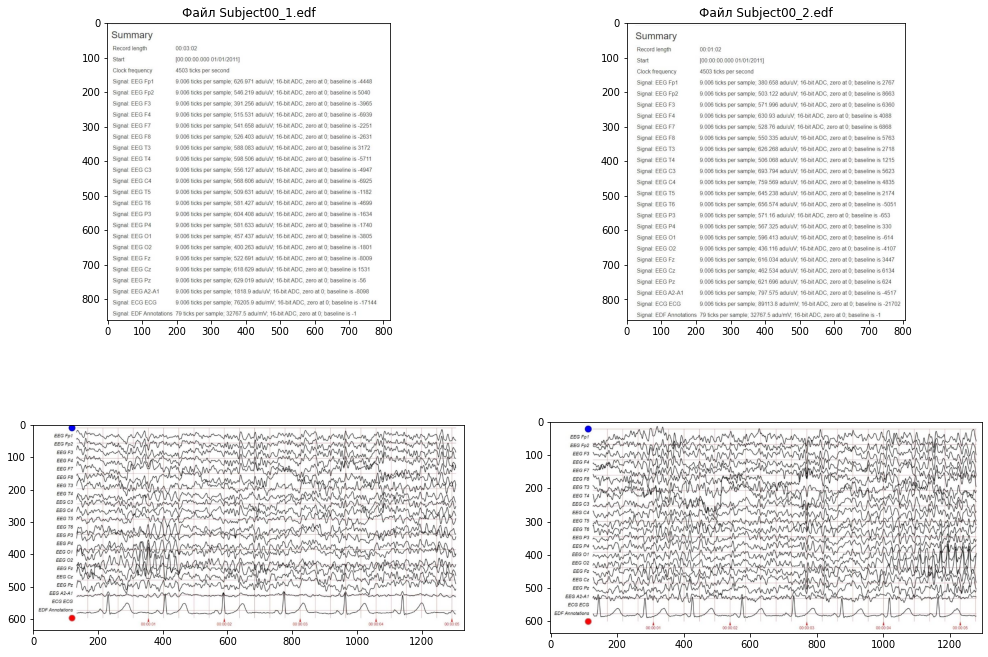

In [2]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(17)
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Файл Subject00_1.edf')
ax1.imshow(mpimg.imread('img/t1.png'))
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Файл Subject00_2.edf')
ax2.imshow(mpimg.imread('img/t2.png'))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(mpimg.imread('img/e1.png'))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(mpimg.imread('img/e2.png'))

(все файлы скачаны)
#### Что это за файлы? 

Открываем readme файлик, и читаем:

The data files with EEG are provided in EDF (European Data Format) format. Each folder contains two recording files per subject: 
* with “_1” postfix -- the recording of the background EEG of a subject (before mental arithmetic task)
* with “_2” postfix -- the recording of EEG during the mental arithmetic task. 


Для дальнейшей работы с файлами понадобится библиотека:
```conda install -c conda-forge pyedflib```

ЗАМЕТИМ, что 4500 ticks per sec.

### Выявление всех альфа-волн

#### Что это? 
Нормальная ритмическая активность ЭЭГ (расслабленное физическое и умственное состояние). 

__Частота альфа-ритма__ варьирует в пределах от 8 до 13 Гц. (Если частота больше, то активные процессы, меньше - сон/сонливость)

In [3]:
from pyedflib import highlevel

In [4]:
def read_edf(path):
    return highlevel.read_edf(path)

sample_1, sample_headers_1, header_1 = read_edf('physionet.org/files/eegmat/1.0.0/Subject00_1.edf')
sample_2, sample_headers_2, header_2 = read_edf('physionet.org/files/eegmat/1.0.0/Subject00_2.edf')

`samples` - сигналы

`sample_headers` - для каждой дорожки откуда измеряли, и статистики

`header` - метаинформация об эксперименте вцелом

Для начала, извлеку нужные мне сигналы:

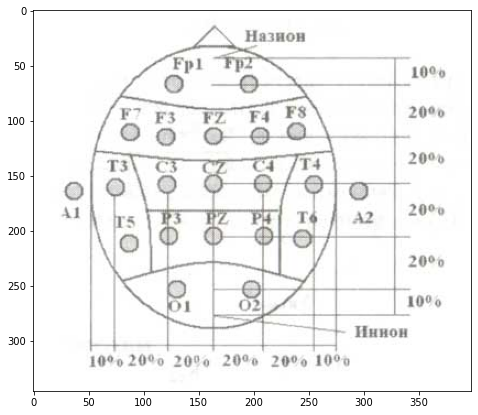

In [5]:
plt.figure(figsize=(15,7)) 
img = mpimg.imread('img/brain.tif')
plt.imshow(img)

In [6]:
sample_headers_1[0]

{'label': 'EEG Fp1',
 'dimension': 'uV',
 'sample_rate': 500,
 'physical_max': 59.35658,
 'physical_min': -45.1698,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': 'HP:0.500000Hz LP:45.000000Hz RF:50Hz',
 'transducer': ''}

Названия электродов включают первую букву латинского названия области, на которую ставится электрод, и номер, указывающий сторону и расположение электрода в пределах этой области.: pre-frontal (Fp), frontal (F), temporal (T), parietal (P), occipital (O), central (C), midline (Z).

__THAT IS WHY__ мне нужны только O и P датчики (там возникают альфа-волны в большинстве своем).

In [7]:
for lab1, lab2 in zip(sample_headers_1, sample_headers_2):
    print(f"{lab1['label']}\t\t{lab2['label']}")

EEG Fp1		EEG Fp1
EEG Fp2		EEG Fp2
EEG F3		EEG F3
EEG F4		EEG F4
EEG F7		EEG F7
EEG F8		EEG F8
EEG T3		EEG T3
EEG T4		EEG T4
EEG C3		EEG C3
EEG C4		EEG C4
EEG T5		EEG T5
EEG T6		EEG T6
EEG P3		EEG P3
EEG P4		EEG P4
EEG O1		EEG O1
EEG O2		EEG O2
EEG Fz		EEG Fz
EEG Cz		EEG Cz
EEG Pz		EEG Pz
EEG A2-A1		EEG A2-A1
ECG ECG		ECG ECG


In [8]:
new_sample_1 = []
new_sample_headers_1 = []
new_sample_2 = []
new_sample_headers_2 = []
for s1, lab1, s2, lab2 in zip(sample_1, sample_headers_1, sample_2, sample_headers_2):
    if 'EEG O' in lab1['label'] or 'EEG P' in lab1['label']:
        new_sample_1.append(s1)
        new_sample_headers_1.append(lab1)    
    if 'EEG O' in lab2['label'] or 'EEG P' in lab2['label']:
        new_sample_2.append(s2)
        new_sample_headers_2.append(lab2)
sample_1 = np.array(new_sample_1)
sample_headers_1 = new_sample_headers_1
sample_2 = np.array(new_sample_2)
sample_headers_2 = new_sample_headers_2

##### Воспользуюсь преобразованием Фурье, как и в прошлый раз:

А нет, не воспользуюсь, так как оно создает гигантские массивы размером 50Гб. До свидания.
НООО, вроде можно использовать и библиотечное, так как нам сказано, что измерения фиксированные, 500 в секунду ('sample_rate': 500).

In [9]:
# сделаю преобразование фурье
def get_freq_and_four(sample, per_seq = 250):
    n = len(sample)
    amplitude = abs(sp.fft.fft(sample))[:n//2]
    time = [i/per_seq for i in range(n//2)]
    freq = sp.fft.fftfreq(n, d=1/per_seq)[:n//2]
    return time, freq, amplitude


def fourier_transform(sample, per_seq = 250):
    f_time = []
    f_freq = []
    f_signals = []
    for s in sample:
        time, freq, amplitude = get_freq_and_four(s, per_seq)
        f_time.append(time)
        f_freq.append(freq)
        f_signals.append(amplitude)
    return np.array(f_signals), np.array(f_freq), np.array(f_signals)


In [10]:
time_1, freq_1, amplitude_1 = fourier_transform(sample_1, 500)
time_2, freq_2, amplitude_2 = fourier_transform(sample_2, 500)

In [11]:
# draw them
def draw_signals(freq, f_signals, label = '', color = np.random.rand(3,), first_n = 8000):
    freq = freq[:first_n]
    f_signals = f_signals[:first_n]
    plt.plot(freq, f_signals, c=color, label = label)

def draw_for_sample(freqs_before, f_samples_before, freqs_after, f_samples_after, sample_headers, name, first_n = 8000):
    print('===================================================\n\t'+
          name.upper()+
          '\n===================================================\n')
    color_b = np.random.rand(3,)
    color_a = np.random.rand(3,)
    for sample_b, freq_b, sample_a, freq_a, head in zip(f_samples_before, freqs_before, f_samples_after, freqs_after, sample_headers):
        plt.figure(figsize=(20, 5))
        if len(sample_a)>0:
            draw_signals(freq_b, sample_b, 'before math', color_b, first_n)
        if len(sample_b)>0:
            draw_signals(freq_a, sample_a, 'after math', color_a, first_n)
        plt.xlabel('Частота, Гц')
        plt.ylabel('')
        plt.title(head['label'])
        plt.legend(ncol=2)
        plt.show()

	FOURIER FAST TRANSFORMATION



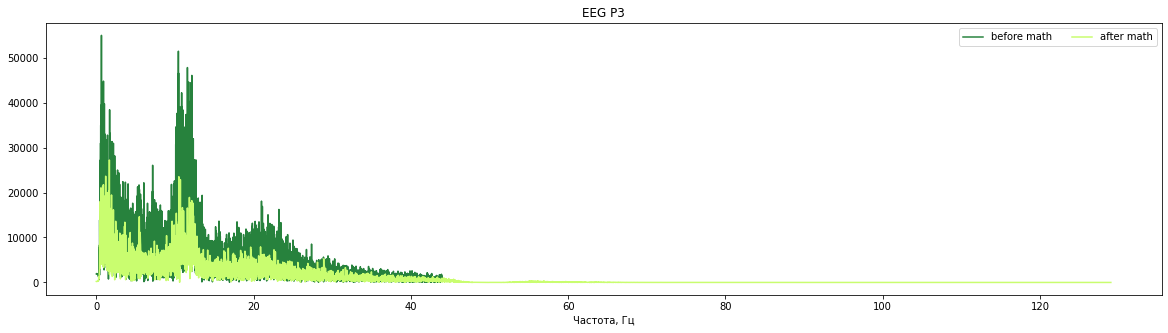

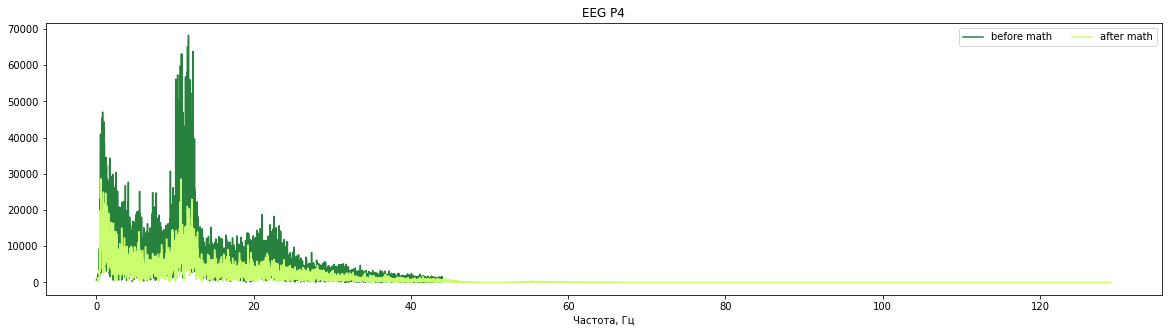

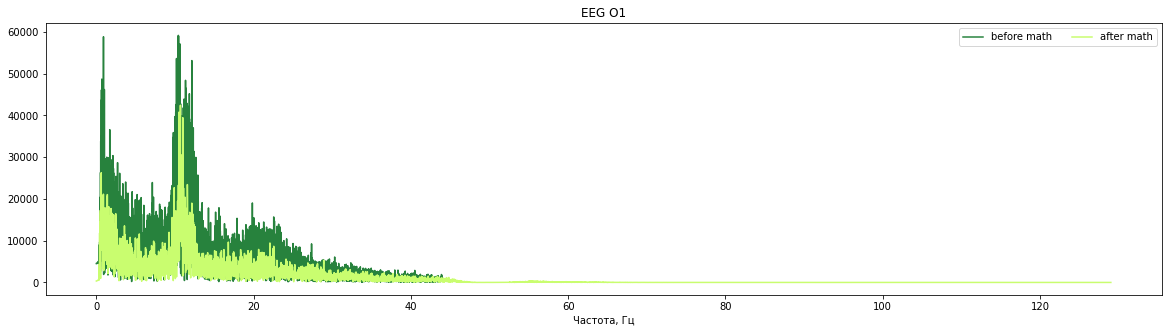

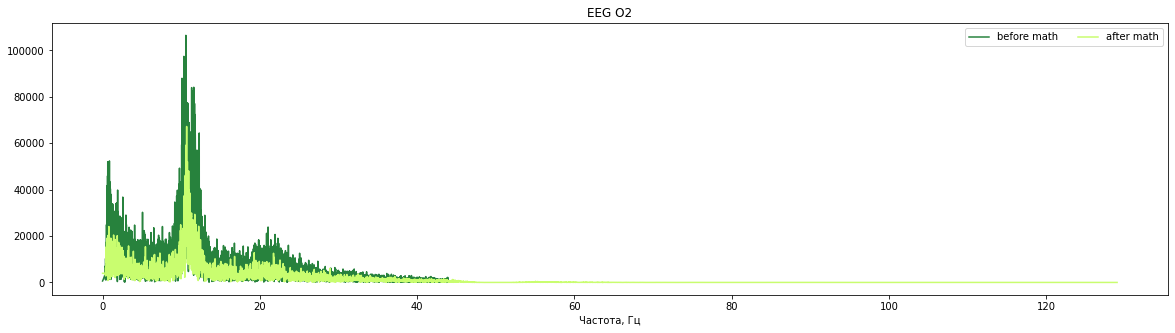

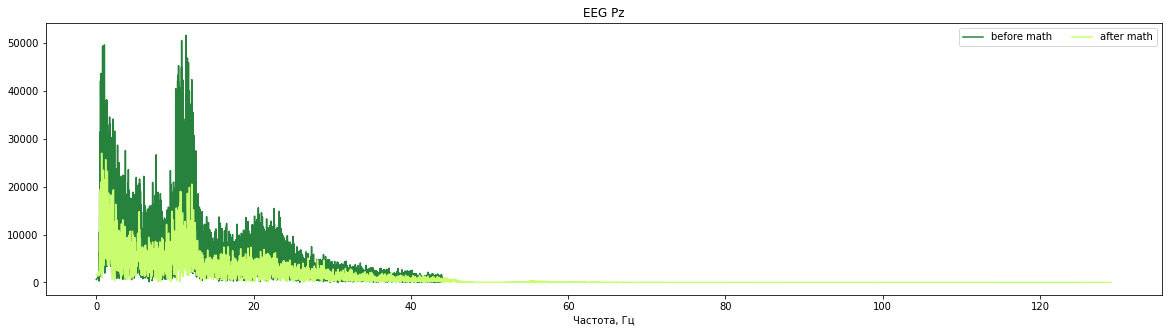

In [12]:
draw_for_sample(freq_1, amplitude_1, freq_2, amplitude_2, sample_headers_1, 'Fourier Fast Transformation')

Далее, нужны альфа-ритмы. Обратимся к тексту:

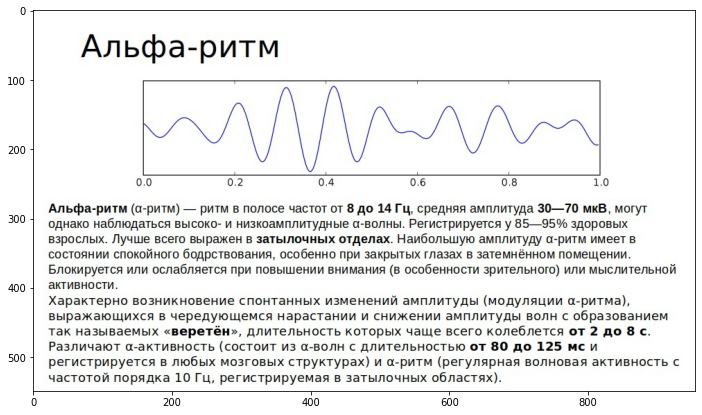

In [13]:
plt.figure(figsize=(15,7)) 
img = mpimg.imread('img/alpha.jpg')
plt.imshow(img)

In [14]:
def cut(freq, f_signals, left_freq, right_freq, left_sig, right_sig):
    take_array = (left_freq < freq) & (freq < right_freq) & (left_sig < f_signals) & (f_signals < right_sig)
    f_signals = f_signals[take_array]
    freq = freq[take_array]
    
    return freq, f_signals

def manage_all(freq, f_signals, left_freq, right_freq, left_sig, right_sig):
    new_freqs = []
    new_sigs = []
    for fr, sig in zip(freq, f_signals):
        new_fr, new_s =  cut(fr, sig, left_freq, right_freq, left_sig, right_sig)
        new_freqs.append(new_fr)
        new_sigs.append(new_s)
    return np.array(new_freqs), np.array(new_sigs)


	FOURIER FAST TRANSFORMATION. ALPHA RHYTMES



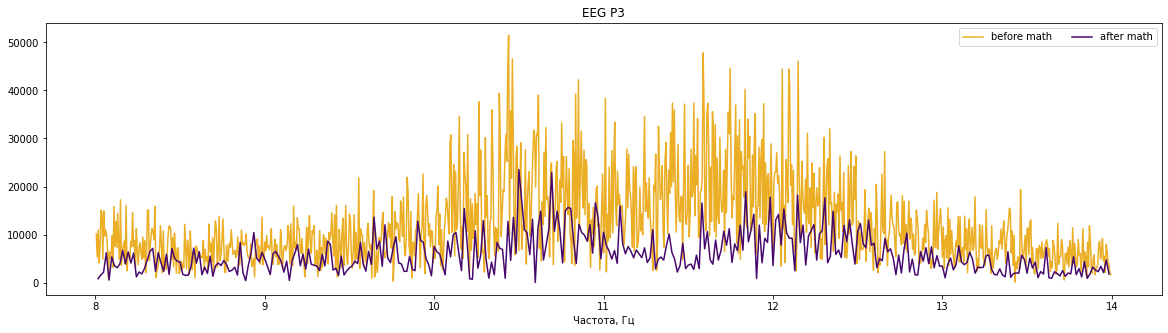

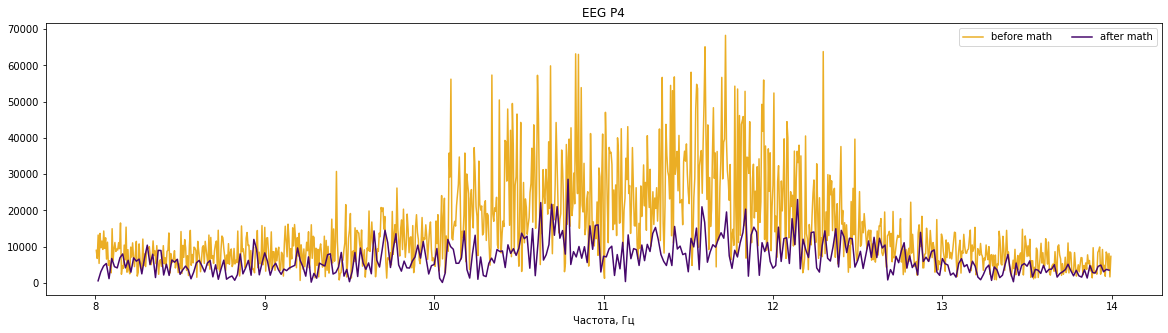

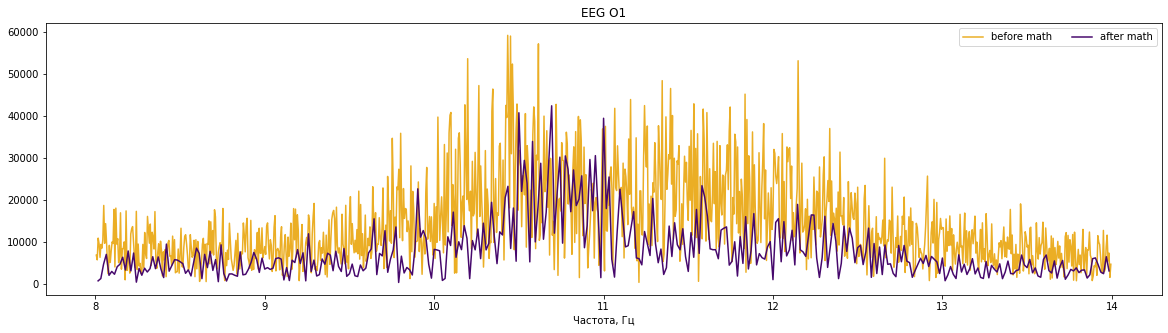

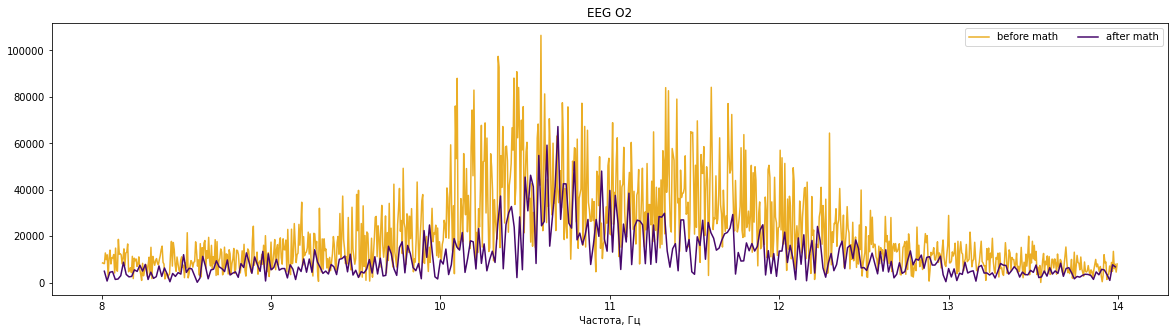

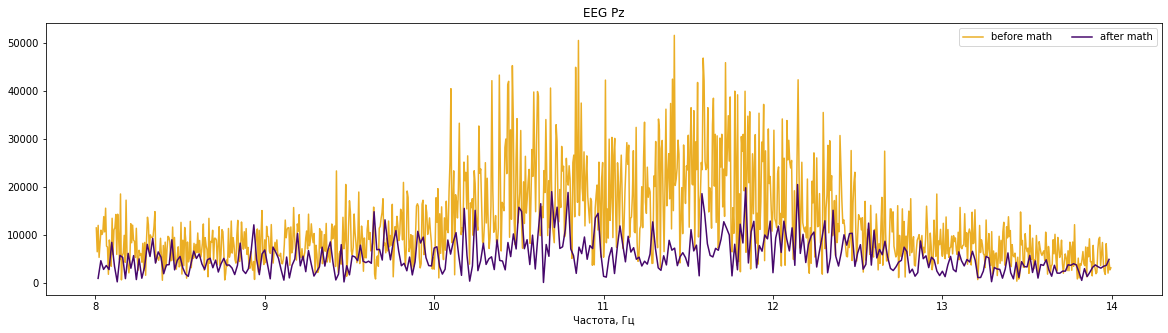

In [15]:
freq_1_cutted, amplitude_1_cutted = manage_all(freq_1, amplitude_1, 8, 14, 0, float('+inf'))
freq_2_cutted, amplitude_2_cutted = manage_all(freq_2, amplitude_2, 8, 14, 0, float('+inf'))
draw_for_sample(freq_1_cutted, amplitude_1_cutted, freq_2_cutted, amplitude_2_cutted, sample_headers_1, 'Fourier Fast Transformation. Alpha rhytmes')

Нууу, собственно да, ясно видно, что во время спокойной активности, они намного ярче проявляются, а во время решения задач, становятся намного слабже).

### Спектральный анализ

Для анализа фоновой биоэлектрической активности мозга широко применяется спектральный метод анализа, описывающий распределение мощности по частотным составляющим изучаемого процесса.

Сначала проведу сглаживание. Для этого воспользуюсь [материалом лекции 8 (DSP Theory course)](
https://github.com/capitanov/dsp-theory/blob/master/src/dsp_theory_8_resampling.ipynb).

Воспользуюсь [материалом лекции 2 (DSP Theory course)](https://github.com/capitanov/dsp-theory/blob/master/src/dsp_theory_2_spectrum.ipynb).

А для окна применю [материал лекции 7 (DSP Theory course)](https://github.com/capitanov/dsp-theory/blob/master/src/dsp_theory_7_windows.ipynb).

In [16]:
import scipy.signal as sig
def spectral_analysis(signals):
    # Удаление из сигнала среднего значения (или линейного тренда) с целью устранения постоянной составляющей.
    new_signals = signals - np.mean(signals)
    
    # Умножение сигнала на сглаживающее окно (см. далее) для уменьшения спектральной утечки, вызываемой разрывами на краях анализируемого фрагмента, возникающими при его периодическом продолжении.
    # Window (Kaiser)
    wn = sig.kaiser(len(new_signals), beta=7)
    new_signals = new_signals * wn
    
    N=100
    # Forward FFT
    xFFT = sp.fft.fftshift(sp.fft.fft(new_signals, N))
    # Magnitude spectrum
    xA = np.abs(xFFT)
    # Phase spectrum
    xF = np.angle(xFFT)
    return xA, xF

+ функция отрисовочки

In [17]:
def draw_spactral_analysis(signals_before,
                           signals_after,
                           sample_headers,
                           name,
                           xlabels,
                           ylabels,
                           color_b = np.random.rand(3,),
                           color_a = np.random.rand(3,)):
    print('=================================\n\t'+name.upper()+'\n=================================\n')
    for signal_b, signal_a, head, xlabel, ylabel in zip(signals_before, signals_after, sample_headers, xlabels, ylabels):
        plt.figure(figsize=(20, 5))
        if len(signal_a)>0:
            plt.plot(signal_b, c=color_b, label = 'before_math')
        if len(signal_b)>0:
            plt.plot(signal_a, c=color_a, label = 'after_math')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(head)
        plt.legend(ncol=2)
        plt.show()

	EEG P3



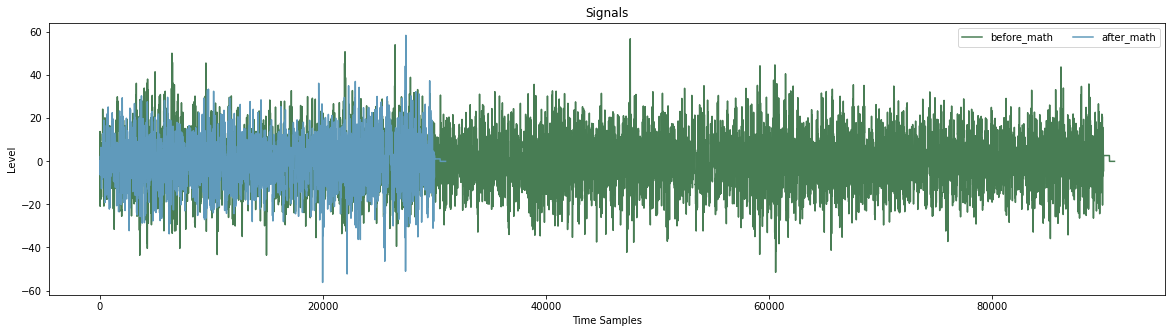

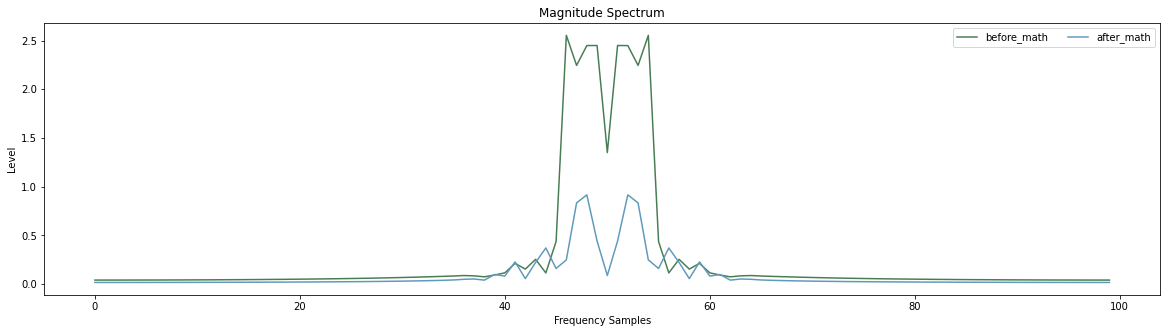

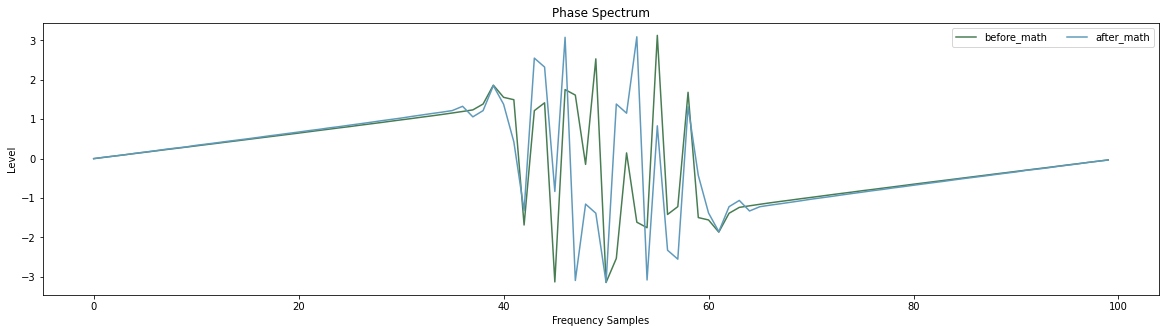

	EEG P4



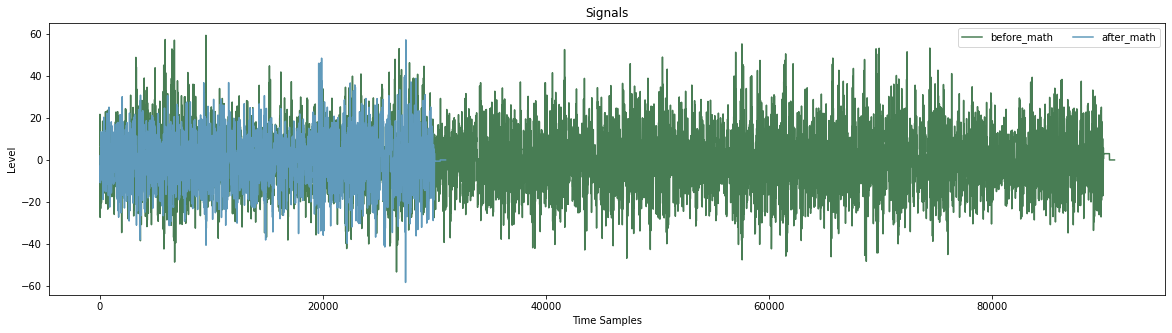

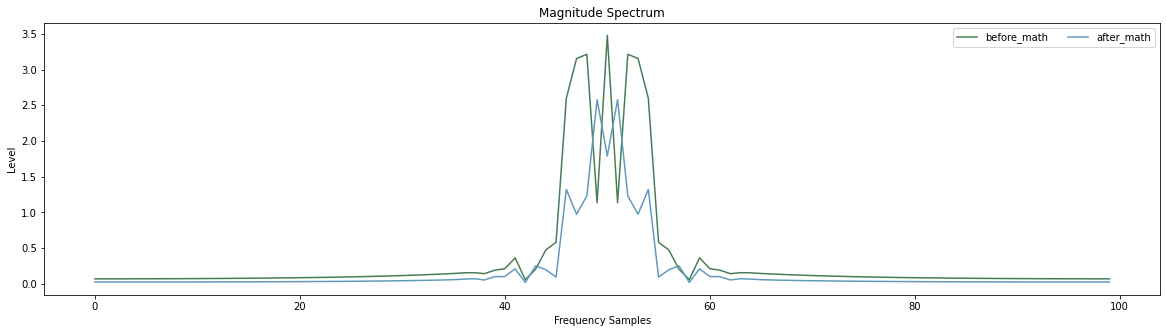

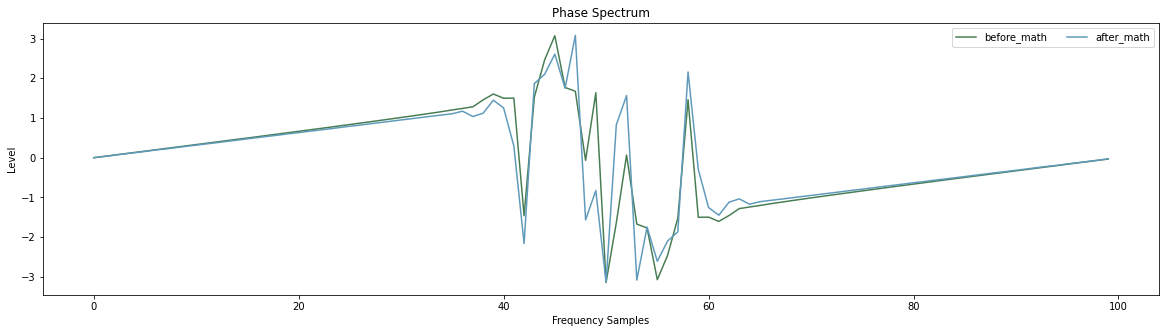

	EEG O1



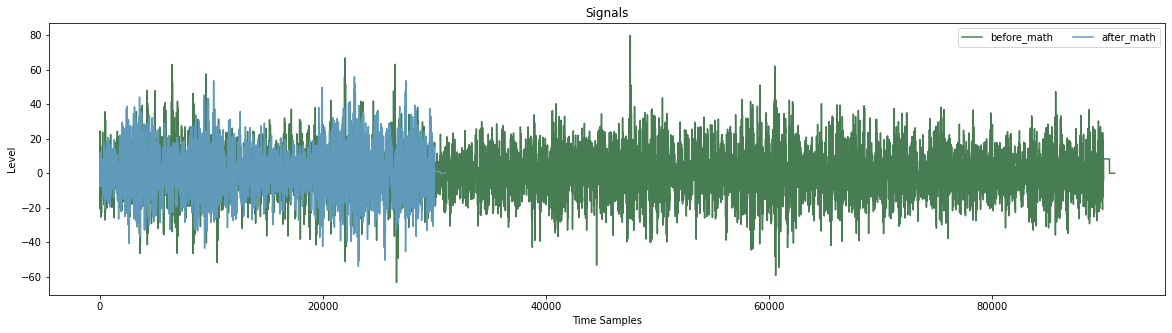

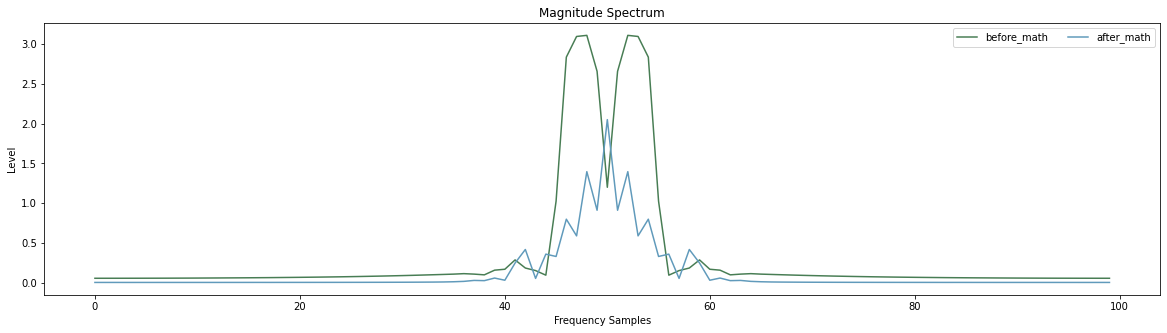

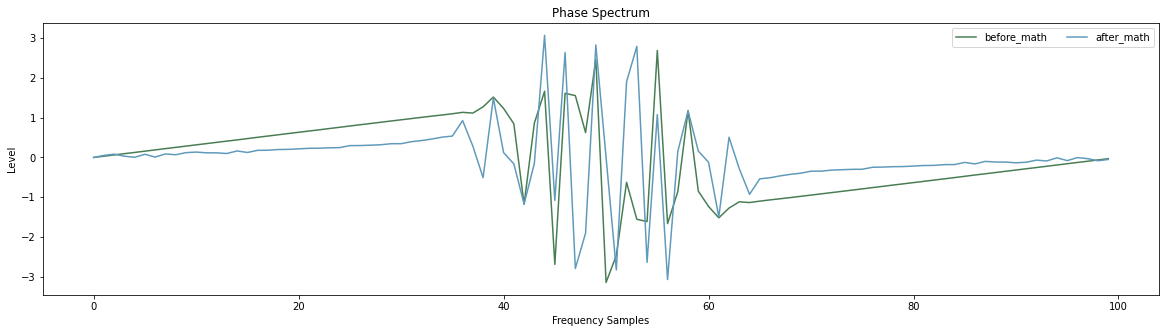

	EEG O2



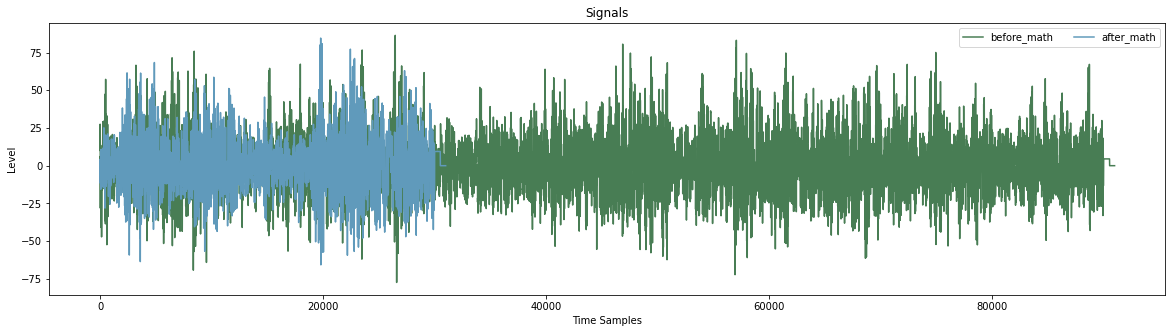

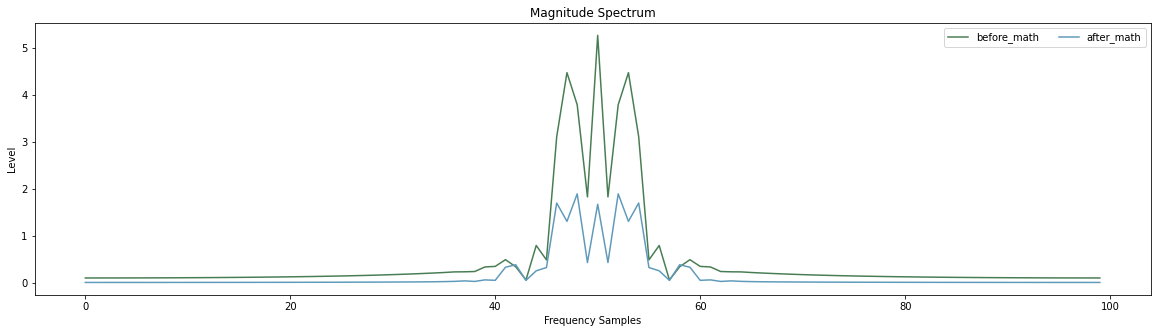

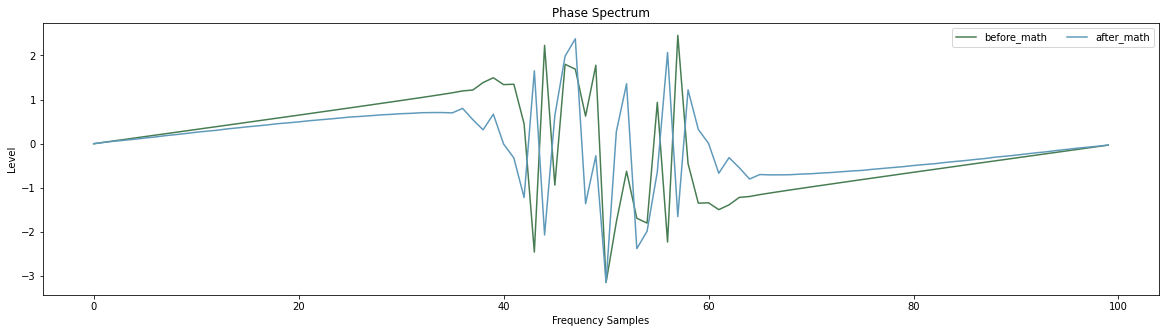

	EEG PZ



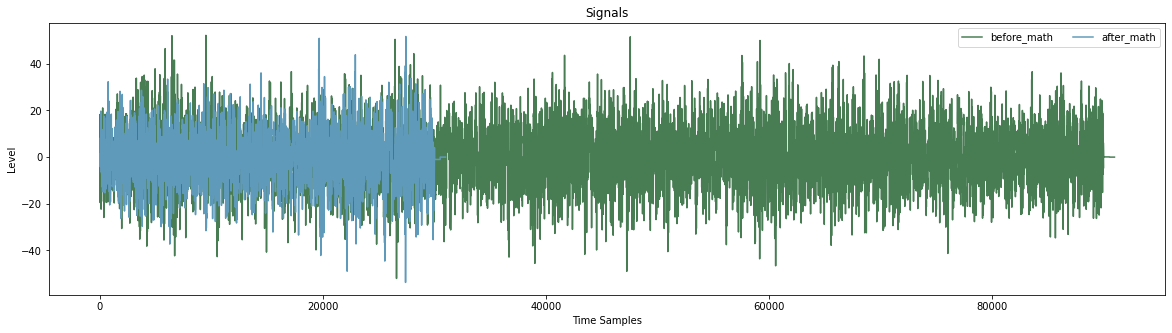

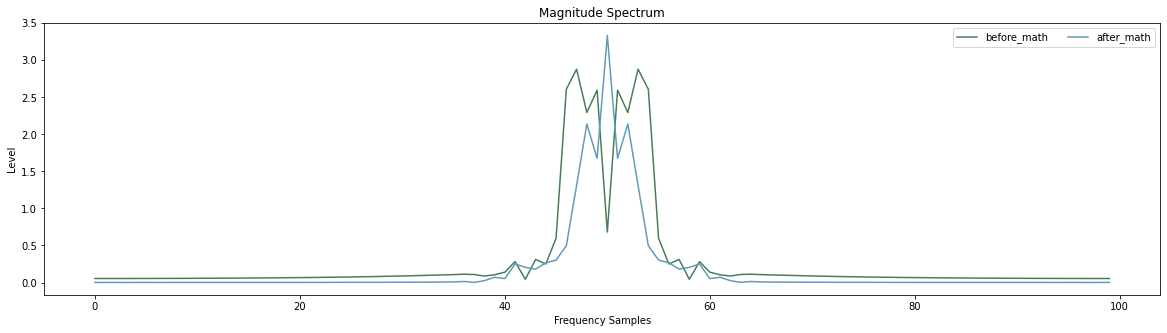

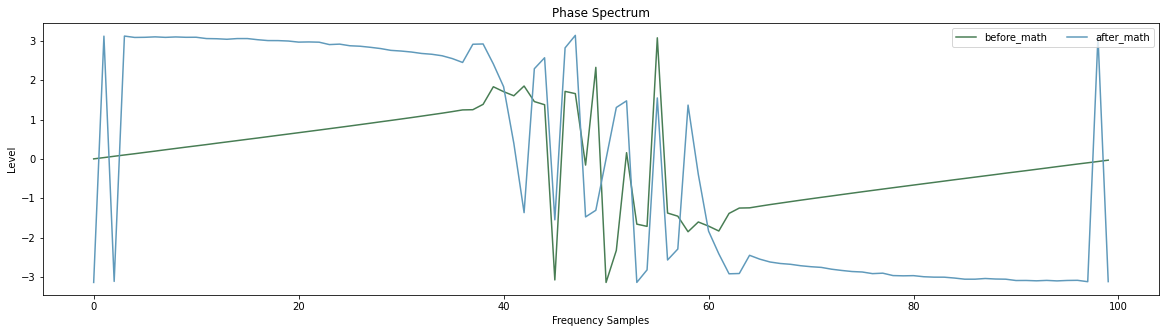

In [18]:
color_b = np.random.rand(3,)
color_a = np.random.rand(3,)
for s1, s2, h1, h2 in zip(sample_1, sample_2, sample_headers_1, sample_headers_2):
    magnitude_spectrum1, phase_spectrum1 = spectral_analysis(s1)
    magnitude_spectrum2, phase_spectrum2 = spectral_analysis(s2)
    titles = ['Signals', 'Magnitude Spectrum', 'Phase Spectrum']
    draw_spactral_analysis([s1, magnitude_spectrum1, phase_spectrum1], 
                           [s2, magnitude_spectrum2, phase_spectrum2],
                           ['Signals', 'Magnitude Spectrum', 'Phase Spectrum'], 
                           h1['label'],
                           ['Time Samples', 'Frequency Samples', 'Frequency Samples'],
                           ['Level' for _ in range(3)],
                           color_b = color_b, 
                           color_a = color_a)

### Выводы
В ходе выполнения лабораторной работы были изучены подходы в использовании ЭЭГ. 

Было выявлено преобладание альфа-ритмов при спокойной активности (больше, чем при решении математических задач)

А так же, произведен спектральный анализ с применением сглаживающего окна.

Мне кажется, возможности использования ЭЭГ для нейроинтерфейсов очень широки, так как можно как предсказывать, чем занят человек, так и давать советы по активности